<a href="https://colab.research.google.com/github/thanosshawn/Bollywoodbuzzlive/blob/main/riceclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [15]:
!cp -r /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1 /content/

In [16]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms , models,datasets
import torch
from PIL import Image
from torch import optim
device='cuda' if torch.cuda.is_available() else 'cpu'
import  glob , numpy as np,pandas as pandas
import matplotlib.pyplot as pyplot
%matplotlib inline
from glob import glob
!pip install torch_summary


In [17]:
train_dir='/content/1/Rice_Image_Dataset'

In [18]:
from torch.utils.data import DataLoader , Dataset


In [19]:
RICE_VARIETIES=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']



In [20]:
train_transforms=transforms.Compose([
    transforms.RandomRotation(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [21]:
train__dataset=torchvision.datasets.ImageFolder(
    train_dir,
    transform=train_transforms
)

In [22]:
train__dataset.classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [23]:
train__dataset.class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [24]:
len(train__dataset)

75000

In [51]:
batch_size=32
num_workers=64


In [52]:
train_loader=DataLoader(
    train__dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)


In [53]:
len(train_loader)

2344

In [54]:
images,labels=next(iter(train_loader))


In [55]:
def imshow(img, title=None):
    # Unnormalize image for visualization (reverse the normalization transformation)
    # The mean and std used for normalization were [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]
    img = img.numpy().transpose((1, 2, 0)) # Convert from C, H, W to H, W, C for matplotlib
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # Multiply by std and add mean
    img = np.clip(img, 0, 1) # Clip values to [0, 1] range
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off') # Hide axes
    plt.show()

In [56]:
import matplotlib.pyplot as plt

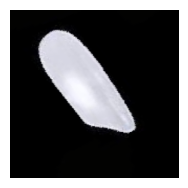

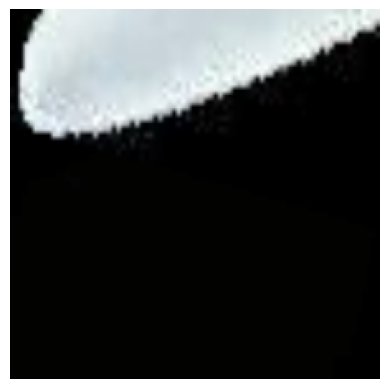

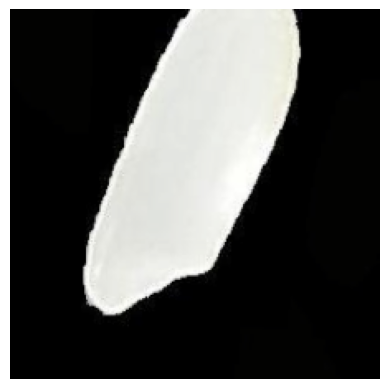

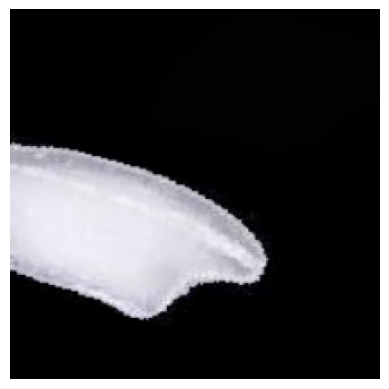

<Figure size 640x480 with 0 Axes>

In [57]:
fig=plt.figure(figsize=(10,8))
for i in range(min(4, len(images))): # Display up to 4 images
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(RICE_VARIETIES[labels[i]])
plt.suptitle("Sample Images from Training Batch")
plt.tight_layout()
plt.show()

In [58]:
class RiceCNN(nn.Module):
  def __init__(self,num_classes=5):
    super(RiceCNN,self).__init__()

    # Input size: (Batch_size, 3, 224, 224) based on your transforms

    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.bn1=nn.BatchNorm2d(32)
    self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(64)
    self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 128x56x56
    self.bn3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128x28x28

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) #Output:256x28x28
    self.bn4 = nn.BatchNorm2d(256)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256x14x14

    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # Output: 512x14x14
    self.bn5 = nn.BatchNorm2d(512)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 512x7x7

    self.fc1=nn.Linear(512*7*7,1024)

    self.dropout=nn.Dropout(0.3)


    self.fc2=nn.Linear(1024,num_classes)

  def forward(self,x):
    x=self.pool1(F.relu(self.bn1(self.conv1(x))))
    x=self.pool2(F.relu(self.bn2(self.conv2(x))))
    x=self.pool3(F.relu(self.bn3(self.conv3(x))))
    x=self.pool4(F.relu(self.bn4(self.conv4(x))))
    x=self.pool5(F.relu(self.bn5(self.conv5(x))))


    x=x.view(-1,512*7*7)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x

In [59]:
from tqdm import tqdm


In [60]:
print(device)

cpu


In [61]:
model=RiceCNN(num_classes=5).to(device)
print(model)

RiceCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [62]:
# loss function
criterion=nn.CrossEntropyLoss()


optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)


In [ ]:
num_epochs=20
print('starting training')
best_val_accuracy=0.0
train_losses=[]
train_accuracies=[]


for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  correct_train=0
  total_train=0

  for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    _,predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()


  avg_train_loss=running_loss/len(train_loader)
  train_losses.append(avg_train_loss)
  train_accuracy=100*correct_train/total_train
  train_accuracies.append(train_accuracy)
  print(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {avg_train_loss:.4f} Accuracy: {train_accuracy:.2f}%")
  scheduler.step()












starting training


Epoch 1/20 [Train]:   0%|          | 6/2344 [01:11<6:24:47,  9.87s/it]